In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
%cd '/content/drive/MyDrive/DATA 245/Project'

/content/drive/.shortcut-targets-by-id/1dBaisw15vXAkSJcnz0pO83MeXqW6AHFn/DATA 245/Project


In [4]:

file_path = '02 artifacts/processed_dataset_WQ.pkl'

try:
    df = pd.read_pickle(file_path)
    print(f"Successfully read '{file_path}'")


    if 'sample_date' in df.columns:
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        df = df.set_index('sample_date').sort_index()

    target_col = 'DissolvedOxygen_mg/L'
    feature_cols = ['SpecificConductance_µS/cm', 'Turbidity_NTU', 'WaterTemperature_°C', 'pH_pH units']

    data = df[[target_col] + feature_cols].copy()

    display(data.head())

except FileNotFoundError:
    print(f"File not found at {file_path}.")

Successfully read '02 artifacts/processed_dataset_WQ.pkl'


,DissolvedOxygen_mg/L,SpecificConductance_µS/cm,Turbidity_NTU,WaterTemperature_°C,pH_pH units
sample_date,,,,,
2000-01-03 09:55:00,11.5,182.0,5.98,8.8,7.5
2000-01-03 10:55:00,11.5,55.0,2.80,9.5,8.0
2000-01-03 11:35:00,11.6,486.0,15.40,9.1,7.9
2000-01-03 12:40:00,11.2,167.0,8.45,9.7,7.9
2000-01-04 10:45:00,4.0,949.0,49.30,8.7,6.8


In [5]:
def create_features(df, target_col):
    df = df.copy()

    df['month'] = df.index.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    lags = [1, 3, 6]
    for lag in lags:
        df[f'target_lag_{lag}'] = df[target_col].shift(lag)

    windows = [3, 6]
    for window in windows:
        df[f'roll_mean_{window}'] = df[target_col].rolling(window=window).mean().shift(1)
        df[f'roll_std_{window}'] = df[target_col].rolling(window=window).std().shift(1)


    df = df.drop(columns=['month'])
    df[target_col] = df[target_col].replace(0, np.nan)
    rolling_std = df[target_col].rolling(window=5).std()
    df.loc[rolling_std < 0.001, target_col] = np.nan
    df[target_col] = df[target_col].interpolate(method='time')
    return df

df_features = create_features(data, target_col)
print(f"Shape: {df_features.shape}")


display(df_features.head())

Shape: (53697, 14)


,DissolvedOxygen_mg/L,SpecificConductance_µS/cm,Turbidity_NTU,WaterTemperature_°C,pH_pH units,month_sin,month_cos,target_lag_1,target_lag_3,target_lag_6,roll_mean_3,roll_std_3,roll_mean_6,roll_std_6
sample_date,,,,,,,,,,,,,,
2000-01-03 09:55:00,11.5,182.0,5.98,8.8,7.5,0.5,0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03 10:55:00,11.5,55.0,2.80,9.5,8.0,0.5,0.866025,11.5,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03 11:35:00,11.6,486.0,15.40,9.1,7.9,0.5,0.866025,11.5,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03 12:40:00,11.2,167.0,8.45,9.7,7.9,0.5,0.866025,11.6,11.5,NaN,11.533333,0.057735,NaN,NaN
2000-01-04 10:45:00,4.0,949.0,49.30,8.7,6.8,0.5,0.866025,11.2,11.5,NaN,11.433333,0.208167,NaN,NaN


In [6]:
# Split data: 80% Train, 20% Test preserving order
split_index = int(len(df_features) * 0.8)

X = df_features.drop(columns=[target_col])
y = df_features[target_col]

print(len(X))

53697


In [7]:
# Concept Drift

n_splits = 5

train_window_size = int(len(X) * 0.3)

print(f"Rolling Training Window Size: ~{train_window_size} samples")

tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=train_window_size)

# Prepare to store results
results = []

Rolling Training Window Size: ~16109 samples


Model                | Avg RMSE   | Avg MAE    | Time (s)  
-------------------------------------------------------
XGBoost              | 1.5388     | 1.0343
Random Forest        | 1.5370     | 1.0335


/tmp/ipython-input-2945987246.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')


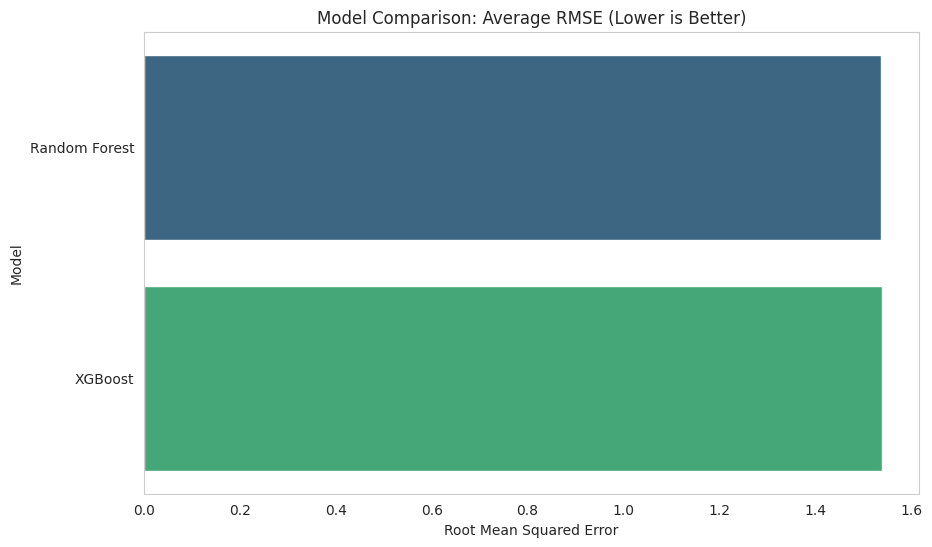

,Model,RMSE,MAE
1,Random Forest,1.537019,1.033543
0,XGBoost,1.538823,1.034318


In [8]:
fold = 1

models = {
    'XGBoost': XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=5,
        random_state=42, n_jobs=-1
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    )
}

# 2. Run Comparison using Rolling CV
# Re-using your tscv from the previous step for consistency
benchmark_results = []

print(f"{'Model':<20} | {'Avg RMSE':<10} | {'Avg MAE':<10} | {'Time (s)':<10}")
print("-" * 55)

for name, model in models.items():
    fold_rmses = []
    fold_maes = []

    # Rolling Window Loop
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Score
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        fold_rmses.append(rmse)
        fold_maes.append(mae)

    # Aggregate Scores
    avg_rmse = np.mean(fold_rmses)
    avg_mae = np.mean(fold_maes)

    benchmark_results.append({
        'Model': name,
        'RMSE': avg_rmse,
        'MAE': avg_mae
    })

    print(f"{name:<20} | {avg_rmse:.4f}     | {avg_mae:.4f}")

# 3. Visualization
results_df = pd.DataFrame(benchmark_results).sort_values(by='RMSE')

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison: Average RMSE (Lower is Better)')
plt.xlabel('Root Mean Squared Error')
plt.grid(axis='x')
plt.show()

display(results_df)
results_df = pd.DataFrame(results)

Calculating error across time folds (this may take a moment)...


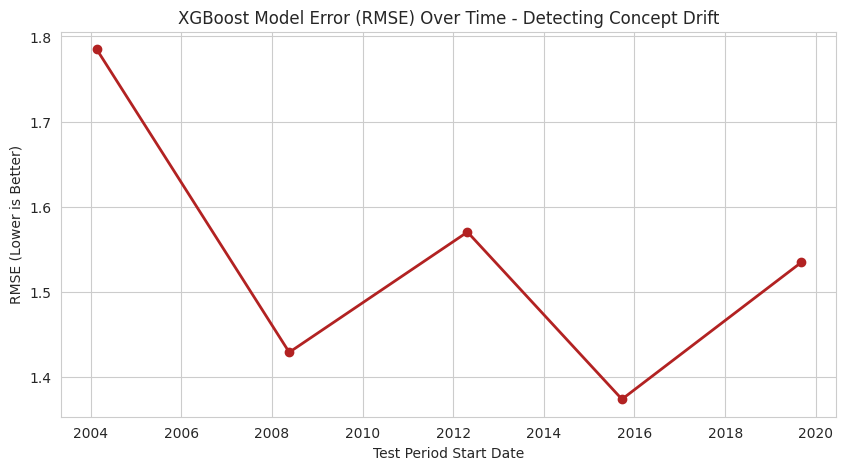

,Test_Start,RMSE
0,2004-02-19 07:45:00,1.785048
1,2008-05-20 08:45:00,1.429375
2,2012-04-25 10:15:00,1.570538
3,2015-09-22 09:45:00,1.374334
4,2019-09-05 11:05:00,1.534818


In [9]:
# Re-calculate performance over time to detect Concept Drift
# We need to capture the score and timestamp for EACH fold

drift_results = []

# Using XGBoost as the representative model for this analysis
model_drift = XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=5,
    random_state=42, n_jobs=-1
)

print("Calculating error across time folds (this may take a moment)...")

for train_index, test_index in tscv.split(X):
    # Split data
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train and Predict
    model_drift.fit(X_train_fold, y_train_fold)
    y_pred_fold = model_drift.predict(X_test_fold)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))

    # Capture the start date of this test period
    test_start_date = y_test_fold.index.min()

    drift_results.append({
        'Test_Start': test_start_date,
        'RMSE': rmse
    })

drift_df = pd.DataFrame(drift_results)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(drift_df['Test_Start'], drift_df['RMSE'], marker='o', linestyle='-', linewidth=2, color='firebrick')
plt.title("XGBoost Model Error (RMSE) Over Time - Detecting Concept Drift")
plt.xlabel("Test Period Start Date")
plt.ylabel("RMSE (Lower is Better)")
plt.grid(True)
plt.show()

display(drift_df)

In [10]:
print("\n--- Average Performance Across All Rolling Folds ---")
print(f"Average RMSE: {drift_df['RMSE'].mean():.4f}")
print(f"Std Dev RMSE: {drift_df['RMSE'].std():.4f}")


--- Average Performance Across All Rolling Folds ---
Average RMSE: 1.5388
Std Dev RMSE: 0.1587


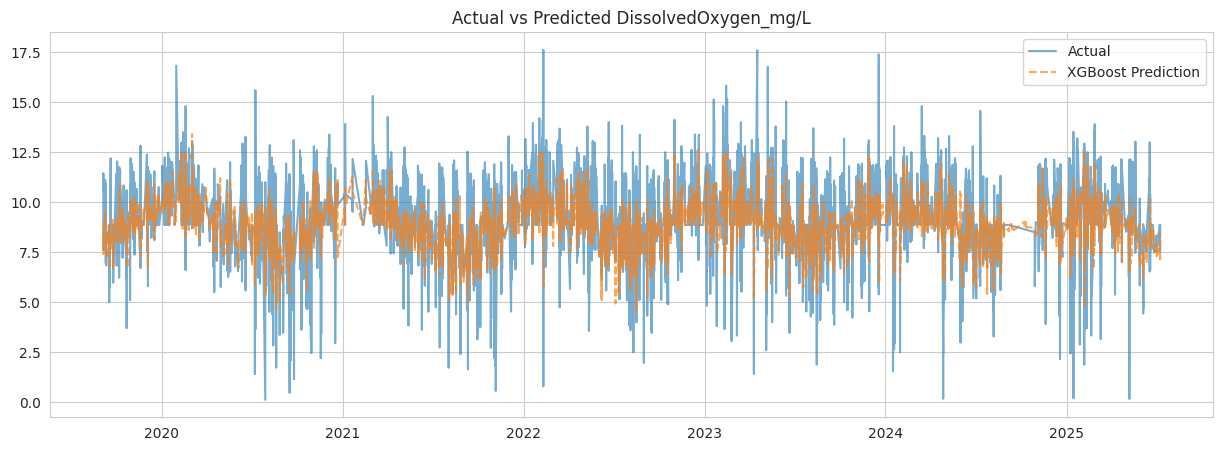

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(y_test.index, y_pred, label='XGBoost Prediction', alpha=0.7, linestyle='--')
plt.legend()
plt.title(f'Actual vs Predicted {target_col}')
plt.show()

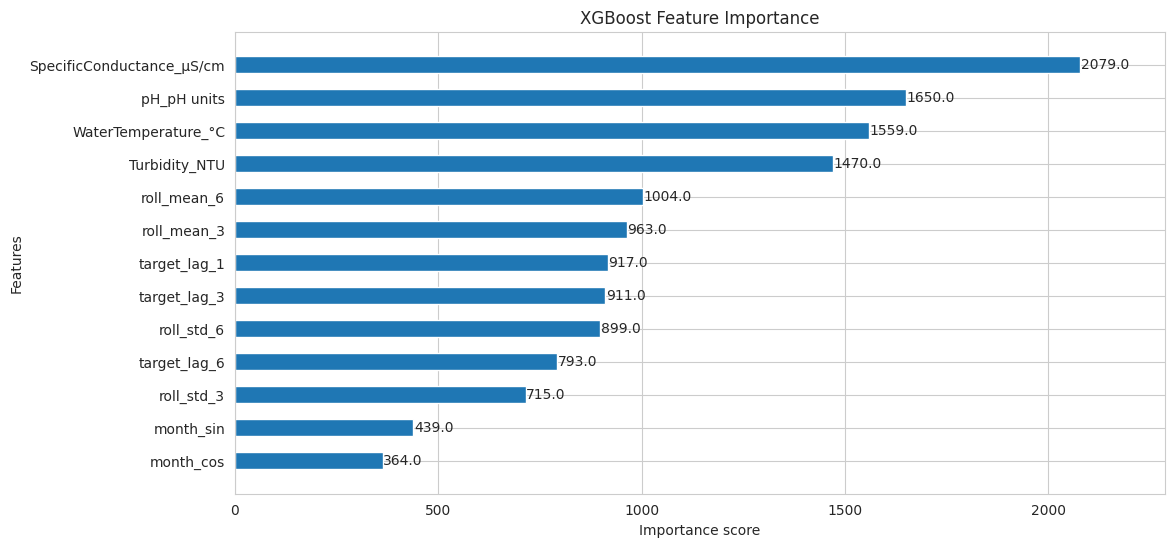

In [12]:
xgb.plot_importance(models['XGBoost'], max_num_features=15, height=0.5)
plt.title("XGBoost Feature Importance")
plt.show()

# Task
Perform hyperparameter tuning for `XGBRegressor` and `RandomForestRegressor` using `RandomizedSearchCV` and the existing `tscv` cross-validator. First, import `RandomizedSearchCV` from `sklearn.model_selection`. Then, define parameter grids for XGBoost (including `learning_rate`, `max_depth`, `subsample`, `colsample_bytree`, `n_estimators`) and Random Forest (including `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`). Run the randomized search on `X` and `y` with `n_iter=10` (or more), using `scoring='neg_root_mean_squared_error'`. Finally, display the best hyperparameters found and the corresponding RMSE scores (converted to positive values) for both models.

## Define Hyperparameter Grids

### Subtask:
Import RandomizedSearchCV and define the hyperparameter search spaces for XGBoost and Random Forest.


**Reasoning**:
Import RandomizedSearchCV and define the hyperparameter search grids for XGBoost and Random Forest as per the instructions.



In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid for XGBRegressor
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 300, 500]
}

# Define hyperparameter grid for RandomForestRegressor
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("XGBoost Parameters Grid:", xgb_params)
print("Random Forest Parameters Grid:", rf_params)

XGBoost Parameters Grid: {'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7], 'subsample': [0.7, 0.8, 1.0], 'colsample_bytree': [0.7, 0.8, 1.0], 'n_estimators': [100, 300, 500]}
Random Forest Parameters Grid: {'n_estimators': [100, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


**Reasoning**:
Run RandomizedSearchCV for both XGBoost and Random Forest using the defined parameter grids and TimeSeriesSplit cross-validator to find the best hyperparameters, then display the results.



In [14]:
# Initialize models with n_jobs=1 to avoid nested parallelism issues with RandomizedSearchCV
xgb_model = XGBRegressor(random_state=42, n_jobs=1)
rf_model = RandomForestRegressor(random_state=42, n_jobs=1)

# Setup RandomizedSearchCV for XGBoost
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=5,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Setup RandomizedSearchCV for Random Forest
rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_params,
    n_iter=5,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the models
print("Running Randomized Search for XGBoost...")
xgb_search.fit(X, y)

print("\nRunning Randomized Search for Random Forest...")
rf_search.fit(X, y)

# Display best parameters and scores
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best XGBoost Params: {xgb_search.best_params_}")
print(f"Best XGBoost RMSE: {-xgb_search.best_score_:.4f}")

print(f"\nBest Random Forest Params: {rf_search.best_params_}")
print(f"Best Random Forest RMSE: {-rf_search.best_score_:.4f}")

Running Randomized Search for XGBoost...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Running Randomized Search for Random Forest...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 